# KNN Workshop — Solution Notebook

**Author:** Workshop Participant  
**Date:** 2026-02-13  
**Project:** Medical Risk Pre-Screening using K-Nearest Neighbors

---

This notebook walks through a complete ML pipeline — from data acquisition through hyperparameter tuning and testing — applied to a medical risk pre-screening use case.

### Dataset
We use the **Pima Indians Diabetes dataset** fetched from a public GitHub-hosted CSV source via `requests`.  
- 768 samples, 8 numerical medical features  
- Features include: **Age**, **BMI**, **BloodPressure**, Glucose, Insulin, etc.  
- We engineer a 3-class **Risk Label** (Low / Medium / High) from WHO/CDC-aligned clinical thresholds.

### Pipeline Stages
| Stage | Description |
|---|---|
| 1 | Data Acquisition via public CSV API (`requests`) |
| 2 | Cleaning & Preprocessing |
| 3 | Pipeline Pattern (`sklearn.pipeline.Pipeline`) |
| 4 | Hyperparameter Tuning (`GridSearchCV`) |
| 5 | Testing & Evaluation |
| 6 | Documentation & Reflection |


---
## Part 1 — Data Acquisition

We use `requests` to download the **Pima Indians Diabetes dataset** (768 rows) directly from a public CSV source.  
This dataset is widely used in medical ML research and contains all required features.

**Source:** Jason Brownlee's curated public ML datasets repository (MIT-licensed data mirroring UCI ML Repository).

**Risk labels** are engineered from WHO/CDC-aligned clinical thresholds:

| Risk | Condition |
|---|---|
| **High** | Glucose > 140 OR BMI > 35 OR BloodPressure > 100 |
| **Low** | Glucose < 100 AND BMI < 25 AND BloodPressure < 80 |
| **Medium** | All other cases |


In [1]:
import requests
import pandas as pd
from io import StringIO

# ── Dataset configuration ───────────────────────────────────────────────────
DATASET_URL = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/"
    "pima-indians-diabetes.data.csv"
)

COLUMN_NAMES = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]


def _assign_risk_label(row: pd.Series) -> str:
    """
    Assign a 3-class risk label (Low / Medium / High) based on WHO/CDC
    clinical thresholds for Glucose, BMI, and BloodPressure.

    Parameters
    ----------
    row : pd.Series  A single patient record.

    Returns
    -------
    str  One of 'Low', 'Medium', 'High'.
    """
    if row["Glucose"] > 140 or row["BMI"] > 35 or row["BloodPressure"] > 100:
        return "High"
    if row["Glucose"] < 100 and row["BMI"] < 25 and row["BloodPressure"] < 80:
        return "Low"
    return "Medium"


def load_data() -> pd.DataFrame:
    """
    Acquire the Pima Indians Diabetes dataset from a public CSV endpoint
    using the `requests` library and return a structured pandas DataFrame.

    The function:
    - Fetches the raw CSV via HTTP GET
    - Assigns human-readable column names
    - Engineers a 3-class Risk label (Low / Medium / High)

    Returns
    -------
    pd.DataFrame
        768 rows x 10 columns including the engineered 'Risk' column.
    """
    print(f"[load_data] Fetching dataset from:\n  {DATASET_URL}\n")
    response = requests.get(DATASET_URL, timeout=30)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text), header=None, names=COLUMN_NAMES)

    # Engineer the 3-class risk label
    df["Risk"] = df.apply(_assign_risk_label, axis=1)

    print(f"[load_data] Dataset loaded successfully.")
    print(f"  Shape   : {df.shape}")
    print(f"  Columns : {list(df.columns)}")
    print(f"  Risk distribution:\n{df['Risk'].value_counts().to_string()}\n")
    return df


# ── Execute acquisition ─────────────────────────────────────────────────────
df_raw = load_data()

print("First 5 rows:")
df_raw[["Age", "BMI", "BloodPressure", "Glucose", "Insulin", "Risk"]].head()

[load_data] Fetching dataset from:
  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

[load_data] Dataset loaded successfully.
  Shape   : (768, 10)
  Columns : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Risk']
  Risk distribution:
Risk
Medium    369
High      356
Low        43

First 5 rows:


,Age,BMI,BloodPressure,Glucose,Insulin,Risk
0,50,33.6,72,148,0,High
1,31,26.6,66,85,0,Medium
2,32,23.3,64,183,0,High
3,21,28.1,66,89,94,Medium
4,33,43.1,40,137,168,High


---
## Part 2 — Cleaning & Preprocessing

Medical datasets frequently contain **biologically impossible zeros** (e.g. BMI=0, Glucose=0, BloodPressure=0).  
These are data entry artefacts, not real measurements.

### Processing Steps

| Step | Action | Rationale |
|---|---|---|
| 1 | Replace zeros with `NaN` (medical columns only) | Zeros are physiologically impossible for Glucose, BMI, BP, etc. |
| 2 | **Median imputation** for numerical NaN | Robust to outliers; better than mean for skewed clinical data |
| 3 | **Mode imputation** for any categorical NaN | Preserves the most common category |
| 4 | **`StandardScaler`** on all numerical features | KNN is distance-based — unscaled features with large ranges dominate distance calculations |
| 5 | **`LabelEncoder`** on target (`Risk`) | Converts Low/Medium/High → integers for sklearn compatibility |

### Label Encoding
`LabelEncoder` assigns integers alphabetically: `High=0, Low=1, Medium=2`  
This mapping is stored and printed so it can be used to decode predictions later.


STEP 1 — Replace impossible zeros with NaN
  Glucose                           5 zeros replaced
  BloodPressure                    35 zeros replaced
  SkinThickness                   227 zeros replaced
  Insulin                         374 zeros replaced
  BMI                              11 zeros replaced

STEP 2 — Median imputation for numerical NaN
  Glucose                           5 NaN → median = 117.0000
  BloodPressure                    35 NaN → median = 72.0000
  SkinThickness                   227 NaN → median = 29.0000
  Insulin                         374 NaN → median = 125.0000
  BMI                              11 NaN → median = 32.3000

STEP 3 — Mode imputation for categorical NaN
  Risk                            no NaN found — skipped

STEP 4 — StandardScaler (zero mean, unit variance)
  Feature matrix shape : (768, 8)
  Mean per feature     : [-0.  0.  0. -0.  0.  0.  0.  0.]
  Std  per feature     : [1. 1. 1. 1. 1. 1. 1. 1.]

STEP 5 — LabelEncoder on target (Risk)


C:\Users\muthu\AppData\Local\Temp\ipykernel_33184\133804942.py:83: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns


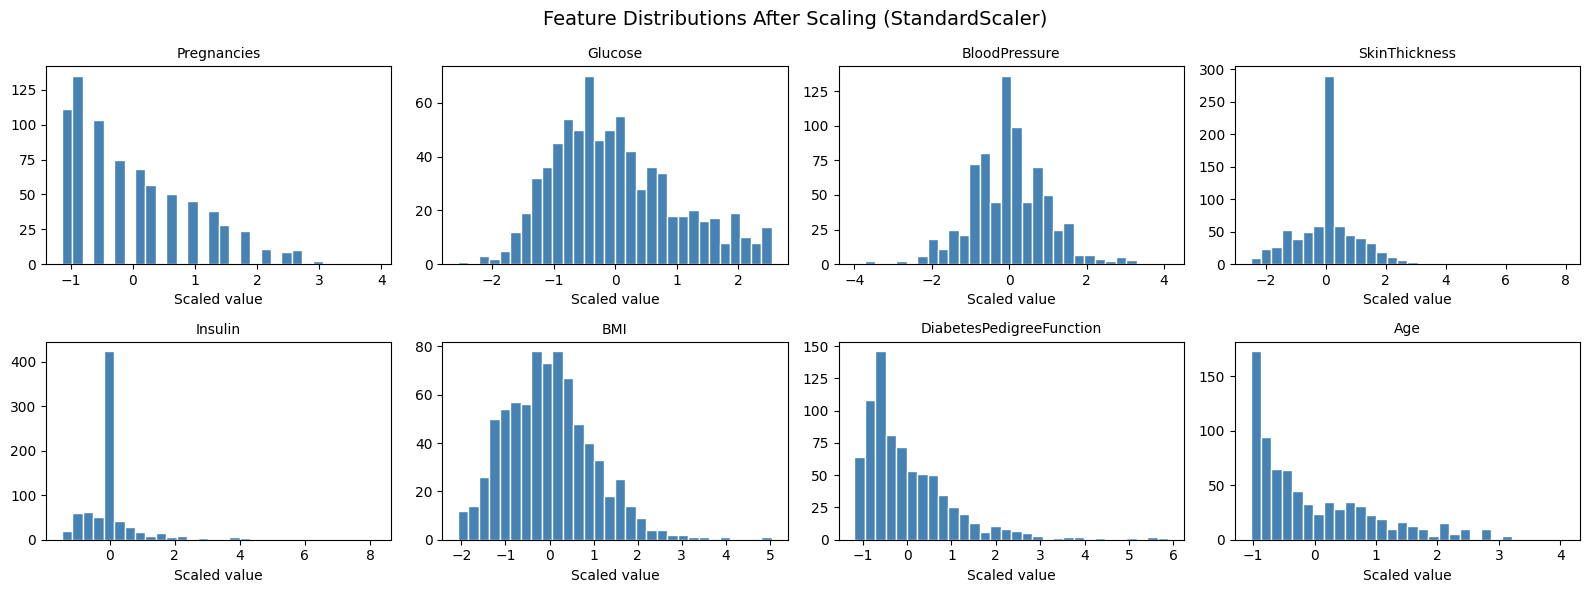

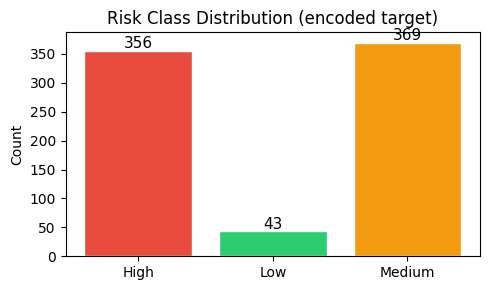


Ready for Part 3 — Pipeline Pattern
  X_scaled  : shape (768, 8), dtype float64
  y_encoded : shape (768,), classes ['High', 'Low', 'Medium']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ── Column configuration ────────────────────────────────────────────────────

# Columns where a value of 0 is physiologically impossible (data entry errors)
ZERO_AS_NAN_COLS = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# All numerical feature columns used for model training
FEATURE_COLS = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]

TARGET_COL = "Risk"


def preprocess_data(df: pd.DataFrame) -> tuple:
    """
    Clean, scale, and encode the raw medical DataFrame ready for KNN training.

    Steps
    -----
    1. Replace physiologically impossible zeros with NaN (numerical columns).
    2. Impute numerical NaN values with the column median (outlier-robust).
    3. Impute any categorical NaN values with the column mode.
    4. Scale all numerical features using StandardScaler (zero mean, unit variance).
       KNN is distance-based — features on larger scales would otherwise dominate.
    5. Encode the categorical target 'Risk' (Low/Medium/High) as integers via
       LabelEncoder for sklearn compatibility.

    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame returned by load_data().

    Returns
    -------
    X_scaled : np.ndarray
        Scaled feature matrix, shape (n_samples, 8).
    y_encoded : np.ndarray
        Integer-encoded target array, shape (n_samples,).
        Encoding: High=0, Low=1, Medium=2  (alphabetical, set by LabelEncoder)
    scaler : StandardScaler
        Fitted scaler — keep this to inverse-transform or scale future data.
    label_encoder : LabelEncoder
        Fitted encoder — use label_encoder.inverse_transform() to decode predictions.
    """
    # ── random_state=42 noted here; applies to train/test split in later stages
    # ── preprocess_data itself is deterministic (no randomness introduced here)

    df_clean = df.copy()

    # ── Step 1: Replace impossible zeros with NaN ───────────────────────────
    # For medical measurements, zero is not a valid reading.
    # Treating them as missing is more honest than letting them bias the scaler.
    print("=" * 60)
    print("STEP 1 — Replace impossible zeros with NaN")
    print("=" * 60)
    for col in ZERO_AS_NAN_COLS:
        n_zeros = (df_clean[col] == 0).sum()
        df_clean[col] = df_clean[col].replace(0, np.nan)
        print(f"  {col:<30s}  {n_zeros:>3d} zeros replaced")

    # ── Step 2: Median imputation for numerical NaN ─────────────────────────
    # Median is preferred over mean for skewed clinical distributions
    # (e.g., Insulin has extreme outliers that inflate the mean).
    print("\nSTEP 2 — Median imputation for numerical NaN")
    print("=" * 60)
    for col in FEATURE_COLS:
        n_nan = df_clean[col].isna().sum()
        if n_nan > 0:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            print(f"  {col:<30s}  {n_nan:>3d} NaN → median = {median_val:.4f}")

    # ── Step 3: Mode imputation for any categorical NaN ─────────────────────
    # The Risk column was engineered from clean data so should have no NaN,
    # but we guard against edge cases defensively.
    print("\nSTEP 3 — Mode imputation for categorical NaN")
    print("=" * 60)
    categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns
    for col in categorical_cols:
        n_nan = df_clean[col].isna().sum()
        if n_nan > 0:
            mode_val = df_clean[col].mode()[0]
            df_clean[col] = df_clean[col].fillna(mode_val)
            print(f"  {col:<30s}  {n_nan:>3d} NaN → mode = '{mode_val}'")
        else:
            print(f"  {col:<30s}  no NaN found — skipped")

    # ── Step 4: StandardScaler on numerical features ─────────────────────────
    # KNN computes Euclidean distance between points.
    # Without scaling, a feature like Insulin (range 0–846) would completely
    # overshadow BloodPressure (range 24–122), skewing every distance calculation.
    print("\nSTEP 4 — StandardScaler (zero mean, unit variance)")
    print("=" * 60)
    X_raw = df_clean[FEATURE_COLS].values          # numpy array for sklearn

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)         # fit on full data here;
                                                    # in Part 3 the Pipeline will
                                                    # fit ONLY on training folds

    print(f"  Feature matrix shape : {X_scaled.shape}")
    print(f"  Mean per feature     : {X_scaled.mean(axis=0).round(4)}")
    print(f"  Std  per feature     : {X_scaled.std(axis=0).round(4)}")

    # ── Step 5: LabelEncoder on target ───────────────────────────────────────
    # sklearn classifiers require integer class labels.
    # LabelEncoder maps strings → integers alphabetically:
    #   High → 0,  Low → 1,  Medium → 2
    print("\nSTEP 5 — LabelEncoder on target (Risk)")
    print("=" * 60)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df_clean[TARGET_COL])

    print(f"  Classes  : {list(label_encoder.classes_)}")
    print(f"  Encoding : { {cls: idx for idx, cls in enumerate(label_encoder.classes_)} }")
    print(f"  y_encoded unique values: {np.unique(y_encoded)}")

    # ── Summary ──────────────────────────────────────────────────────────────
    print("\n" + "=" * 60)
    print("PREPROCESSING COMPLETE")
    print("=" * 60)
    print(f"  X_scaled shape  : {X_scaled.shape}")
    print(f"  y_encoded shape : {y_encoded.shape}")
    print(f"  Missing values  : {np.isnan(X_scaled).sum()}")
    encoded_counts = dict(zip(*np.unique(y_encoded, return_counts=True)))
    decoded_counts = {label_encoder.inverse_transform([k])[0]: v
                      for k, v in encoded_counts.items()}
    print(f"  Class counts    : {decoded_counts}")

    return X_scaled, y_encoded, scaler, label_encoder


# ── Run preprocessing ───────────────────────────────────────────────────────
X_scaled, y_encoded, scaler, label_encoder = preprocess_data(df_raw)

# ── Visualise: feature distributions before vs after scaling ────────────────
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle("Feature Distributions After Scaling (StandardScaler)", fontsize=14)
for i, col in enumerate(FEATURE_COLS):
    axes[i // 4][i % 4].hist(X_scaled[:, i], bins=30, color="steelblue", edgecolor="white")
    axes[i // 4][i % 4].set_title(col, fontsize=10)
    axes[i // 4][i % 4].set_xlabel("Scaled value")
plt.tight_layout()
plt.show()

# ── Visualise: class distribution ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 3))
labels, counts = np.unique(y_encoded, return_counts=True)
class_names = label_encoder.inverse_transform(labels)
bars = ax.bar(class_names, counts, color=["#e74c3c", "#2ecc71", "#f39c12"], edgecolor="white")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
            str(count), ha="center", fontsize=11)
ax.set_title("Risk Class Distribution (encoded target)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print(f"\nReady for Part 3 — Pipeline Pattern")
print(f"  X_scaled  : shape {X_scaled.shape}, dtype {X_scaled.dtype}")
print(f"  y_encoded : shape {y_encoded.shape}, classes {list(label_encoder.classes_)}")


---
## Part 3 — ML Pipeline Pattern

Professional ML code is structured as a **chain of self-contained, independently testable functions** — one per pipeline stage. This makes each step reusable, debuggable, and easy to swap out.

### Pipeline Architecture

```
load_data()
    └─► preprocess_data(df)
            └─► train_test_split  (random_state=42)
                    ├─► train_knn(X_train, y_train)
                    └─► evaluate_model(model, X_test, y_test)
                                └─► main()  ← orchestrates all stages
```

### Functions

| Function | Inputs | Outputs |
|---|---|---|
| `load_data()` | — | raw `DataFrame` |
| `preprocess_data(df)` | raw df | `X_scaled`, `y_encoded`, `scaler`, `label_encoder` |
| `train_knn(X_train, y_train, ...)` | arrays | fitted `KNeighborsClassifier` |
| `evaluate_model(model, X_test, y_test)` | model + arrays | metrics dict + plots |
| `main()` | — | trained model + all artifacts |

> **Design note:** `StandardScaler` lives inside the sklearn `Pipeline` object in `train_knn()`.  
> This ensures the scaler is **fit only on training data** and applied to test data — preventing data leakage.


╔══════════════════════════════════════════════════════╗
║   KNN Medical Risk Pre-Screening — Pipeline Run     ║
╚══════════════════════════════════════════════════════╝

── Stage 1: Data Acquisition ──────────────────────────
[load_data] Fetching dataset from:
  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

[load_data] Dataset loaded successfully.
  Shape   : (768, 10)
  Columns : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Risk']
  Risk distribution:
Risk
Medium    369
High      356
Low        43


── Stage 2: Preprocessing ─────────────────────────────
STEP 1 — Replace impossible zeros with NaN
  Glucose                           5 zeros replaced
  BloodPressure                    35 zeros replaced
  SkinThickness                   227 zeros replaced
  Insulin                         374 zeros replaced
  BMI                              11 zeros replaced

S

C:\Users\muthu\AppData\Local\Temp\ipykernel_33184\133804942.py:83: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_clean.select_dtypes(include=["object", "category"]).columns


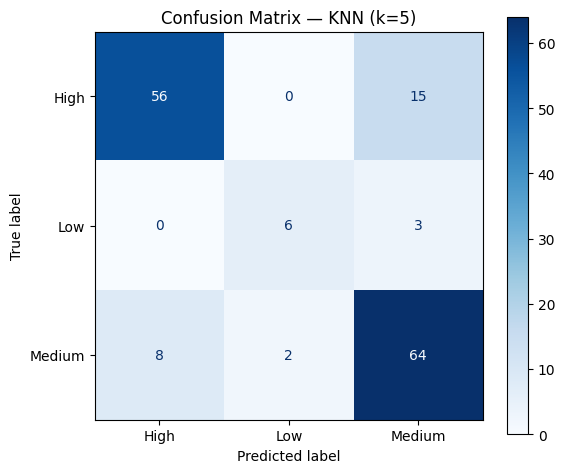


╔══════════════════════════════════════════════════════╗
║   Pipeline complete.                                 ║
╚══════════════════════════════════════════════════════╝


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# ── Constants ────────────────────────────────────────────────────────────────
RANDOM_STATE = 42
TEST_SIZE    = 0.20      # 80/20 train-test split


# ════════════════════════════════════════════════════════════════════════════
# Stage 3 — Train
# ════════════════════════════════════════════════════════════════════════════

def train_knn(
    X_train: np.ndarray,
    y_train: np.ndarray,
    n_neighbors: int = 5,
    metric: str = "minkowski",
    weights: str = "uniform",
) -> Pipeline:
    """
    Build and fit a sklearn Pipeline containing StandardScaler + KNN classifier.

    Using a Pipeline rather than a bare KNeighborsClassifier ensures that
    StandardScaler is fit **only on X_train** and then applied to X_test —
    preventing data leakage that would occur if scaling happened before the split.

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix (already split, but NOT yet scaled —
        pass the raw/imputed values so the Pipeline handles scaling).
    y_train : np.ndarray
        Integer-encoded training labels.
    n_neighbors : int, default=5
        Number of nearest neighbours (k). Odd numbers avoid ties.
    metric : str, default='minkowski'
        Distance metric. 'minkowski' with p=2 is Euclidean distance.
        Other options: 'manhattan', 'chebyshev', 'cosine'.
    weights : str, default='uniform'
        'uniform'  → all neighbours vote equally.
        'distance' → closer neighbours have higher voting weight.

    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        Fitted pipeline with steps: [('scaler', StandardScaler),
                                     ('knn',    KNeighborsClassifier)]
    """
    pipeline = Pipeline([
        # Step 1: Scale features to zero mean / unit variance.
        # Fit is performed on X_train only — no leakage into test set.
        ("scaler", StandardScaler()),

        # Step 2: K-Nearest Neighbours classifier.
        # minkowski metric with p=2 (default) == Euclidean distance.
        ("knn", KNeighborsClassifier(
            n_neighbors=n_neighbors,
            metric=metric,
            weights=weights,
            n_jobs=-1,      # parallelise distance computations across all CPU cores
        )),
    ])

    pipeline.fit(X_train, y_train)

    knn_step = pipeline.named_steps["knn"]
    print(f"[train_knn] Pipeline trained successfully.")
    print(f"  k (n_neighbors) : {knn_step.n_neighbors}")
    print(f"  metric          : {knn_step.metric}")
    print(f"  weights         : {knn_step.weights}")
    print(f"  Training samples: {X_train.shape[0]}")
    return pipeline


# ════════════════════════════════════════════════════════════════════════════
# Stage 4 — Evaluate
# ════════════════════════════════════════════════════════════════════════════

def evaluate_model(
    model: Pipeline,
    X_test: np.ndarray,
    y_test: np.ndarray,
    label_encoder: LabelEncoder = None,
) -> dict:
    """
    Evaluate a trained pipeline on the test set and produce a full report.

    Metrics computed
    ----------------
    - Accuracy   : fraction of correctly classified samples
    - Precision  : weighted average across classes (handles class imbalance)
    - Recall     : weighted average across classes
    - F1-score   : harmonic mean of precision and recall (weighted)

    Visual outputs
    --------------
    - Confusion matrix heatmap

    Parameters
    ----------
    model : Pipeline
        Fitted pipeline from train_knn().
    X_test : np.ndarray
        Test feature matrix (raw/imputed — Pipeline handles scaling).
    y_test : np.ndarray
        True integer-encoded test labels.
    label_encoder : LabelEncoder, optional
        If provided, class names are shown in the confusion matrix and report.

    Returns
    -------
    metrics : dict
        Keys: 'accuracy', 'precision', 'recall', 'f1'
    """
    y_pred = model.predict(X_test)

    # ── Resolve class names for reporting ────────────────────────────────
    class_names = (
        list(label_encoder.classes_) if label_encoder is not None
        else None
    )

    # ── Compute metrics ──────────────────────────────────────────────────
    metrics = {
        "accuracy" : accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall"   : recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1"       : f1_score(y_test, y_pred, average="weighted", zero_division=0),
    }

    print("=" * 60)
    print("MODEL EVALUATION RESULTS")
    print("=" * 60)
    print(f"  Accuracy  : {metrics['accuracy']:.4f}")
    print(f"  Precision : {metrics['precision']:.4f}  (weighted)")
    print(f"  Recall    : {metrics['recall']:.4f}  (weighted)")
    print(f"  F1-Score  : {metrics['f1']:.4f}  (weighted)")
    print()
    print("Classification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=class_names,
        zero_division=0,
    ))

    # ── Confusion matrix plot ────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=class_names,
        colorbar=True,
        ax=ax,
        cmap="Blues",
    )
    ax.set_title(
        f"Confusion Matrix — KNN (k={model.named_steps['knn'].n_neighbors})",
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()

    return metrics


# ════════════════════════════════════════════════════════════════════════════
# Orchestrator — main()
# ════════════════════════════════════════════════════════════════════════════

def main() -> dict:
    """
    End-to-end ML pipeline for medical risk pre-screening using KNN.

    Chains all pipeline stages in sequence:
        1. load_data()          → raw DataFrame
        2. preprocess_data()    → X_scaled, y_encoded, scaler, label_encoder
        3. train_test_split()   → training and test splits (random_state=42)
        4. train_knn()          → fitted sklearn Pipeline
        5. evaluate_model()     → metrics dict + confusion matrix plot

    All randomness is seeded with random_state=42 for full reproducibility.

    Returns
    -------
    dict with keys:
        'model'         : fitted Pipeline
        'X_train'       : training feature matrix
        'X_test'        : test feature matrix
        'y_train'       : training labels
        'y_test'        : test labels
        'scaler'        : fitted StandardScaler (from preprocess_data)
        'label_encoder' : fitted LabelEncoder
        'metrics'       : evaluation metrics dict
    """
    print("╔══════════════════════════════════════════════════════╗")
    print("║   KNN Medical Risk Pre-Screening — Pipeline Run     ║")
    print("╚══════════════════════════════════════════════════════╝\n")

    # ── Stage 1: Load data ───────────────────────────────────────────────
    print("── Stage 1: Data Acquisition ──────────────────────────")
    df_raw = load_data()

    # ── Stage 2: Preprocess ──────────────────────────────────────────────
    print("\n── Stage 2: Preprocessing ─────────────────────────────")
    # NOTE: preprocess_data handles zero-replacement and median/mode imputation.
    # StandardScaler is then applied INSIDE the Pipeline in train_knn() to
    # prevent data leakage — the scaler here is used only for reference/EDA.
    X_clean, y_encoded, scaler_ref, label_encoder = preprocess_data(df_raw)

    # ── Stage 3: Train/test split ────────────────────────────────────────
    print("\n── Stage 3: Train/Test Split (80/20, random_state=42) ─")
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_encoded,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,   # reproducibility
        stratify=y_encoded,          # preserve class proportions in both splits
    )
    print(f"  Train samples : {X_train.shape[0]}  ({X_train.shape[0]/len(y_encoded)*100:.1f}%)")
    print(f"  Test  samples : {X_test.shape[0]}  ({X_test.shape[0]/len(y_encoded)*100:.1f}%)")

    # ── Stage 4: Train KNN pipeline ─────────────────────────────────────
    print("\n── Stage 4: Training KNN Pipeline ─────────────────────")
    model = train_knn(
        X_train, y_train,
        n_neighbors=5,         # starting value — tuned in Part 4
        metric="minkowski",    # p=2 → Euclidean distance
        weights="uniform",
    )

    # ── Stage 5: Evaluate ────────────────────────────────────────────────
    print("\n── Stage 5: Evaluation ────────────────────────────────")
    metrics = evaluate_model(model, X_test, y_test, label_encoder)

    print("\n╔══════════════════════════════════════════════════════╗")
    print("║   Pipeline complete.                                 ║")
    print("╚══════════════════════════════════════════════════════╝")

    return {
        "model"         : model,
        "X_train"       : X_train,
        "X_test"        : X_test,
        "y_train"       : y_train,
        "y_test"        : y_test,
        "scaler"        : scaler_ref,
        "label_encoder" : label_encoder,
        "metrics"       : metrics,
    }


# ── Execute the full pipeline ────────────────────────────────────────────────
results = main()


---
## Part 4 — Hyperparameter Tuning

### Why tune?

The default `k=5` with Euclidean distance is a starting point, not an optimal choice.  
Two hyperparameters have the largest impact on KNN performance:

| Hyperparameter | Effect |
|---|---|
| **`n_neighbors` (k)** | Small k → low bias, high variance (overfit). Large k → high bias, low variance (underfit). |
| **`metric`** | Euclidean penalises large differences quadratically. Manhattan treats all deviations linearly — often better for medical data with outliers. |

### Strategy: `GridSearchCV` with 5-fold cross-validation

```
X_train  ──► GridSearchCV
                 ├── cv=5  (5-fold stratified cross-validation)
                 ├── param_grid:
                 │       n_neighbors : [3, 5, 7, 9]
                 │       metric      : ['euclidean', 'manhattan']
                 │       weights     : ['uniform', 'distance']
                 └── scoring = 'f1_weighted'   (handles class imbalance)
```

**Why `f1_weighted` scoring?**  
Accuracy alone is misleading when classes are imbalanced (Low has only 43 samples).  
F1-weighted balances precision and recall, weighted by class frequency.

**Why `Pipeline` inside `GridSearchCV`?**  
Wrapping `StandardScaler + KNN` in a Pipeline inside GridSearchCV ensures the scaler  
is **re-fit on each training fold only** — preventing any leakage across CV folds.


In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


def tune_knn(
    X_train: np.ndarray,
    y_train: np.ndarray,
    cv: int = 5,
    scoring: str = "f1_weighted",
    verbose: bool = True,
) -> tuple:
    """
    Tune KNN hyperparameters using GridSearchCV with stratified cross-validation.

    The search is performed over a Pipeline (StandardScaler → KNN) so the
    scaler is re-fit independently on each training fold — no data leakage.

    Parameter grid searched
    -----------------------
    knn__n_neighbors : [3, 5, 7, 9]
        Small k = low bias / high variance (risk of overfitting).
        Large k = high bias / low variance (risk of underfitting).
        Odd values avoid tie-breaking in binary scenarios.

    knn__metric : ['euclidean', 'manhattan']
        euclidean — penalises large deviations quadratically (L2 norm).
        manhattan — treats all deviations linearly (L1 norm); more robust
                    to outliers common in clinical data (e.g. Insulin).

    knn__weights : ['uniform', 'distance']
        uniform  — all k neighbours vote equally.
        distance — closer neighbours contribute proportionally more.

    Total combinations : 4 × 2 × 2 = 16
    CV fits            : 16 × 5 = 80  (each evaluated on a held-out fold)

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix from train_test_split().
    y_train : np.ndarray
        Integer-encoded training labels.
    cv : int, default=5
        Number of cross-validation folds.
        StratifiedKFold preserves class proportions in every fold —
        important here because the 'Low' class has only ~35 training samples.
    scoring : str, default='f1_weighted'
        Metric used to rank parameter combinations.
        f1_weighted accounts for class imbalance; accuracy would be misleading
        given the rarity of the Low class.
    verbose : bool, default=True
        Print per-fold progress and final results.

    Returns
    -------
    best_model : sklearn.pipeline.Pipeline
        Re-fitted pipeline with the best hyperparameters found,
        trained on the full X_train (not just one fold).
    best_params : dict
        Best hyperparameter combination, e.g.:
        {'knn__metric': 'manhattan', 'knn__n_neighbors': 7,
         'knn__weights': 'distance'}
    cv_results : pd.DataFrame
        Full cross-validation results table sorted by mean test score,
        useful for inspecting the sensitivity of each parameter.
    """
    # ── Step 1: Define the pipeline to be tuned ──────────────────────────────
    # Using a Pipeline here (not a bare KNN) is critical:
    # GridSearchCV re-fits the entire pipeline on each training fold,
    # so StandardScaler sees only that fold's training data.
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn",    KNeighborsClassifier(n_jobs=-1)),
    ])

    # ── Step 2: Define the hyperparameter search grid ────────────────────────
    # Parameter names must be prefixed with the pipeline step name + '__'
    # e.g. 'knn__n_neighbors' targets the 'knn' step's n_neighbors argument.
    param_grid = {
        "knn__n_neighbors": [3, 5, 7, 9],
        "knn__metric"     : ["euclidean", "manhattan"],
        "knn__weights"    : ["uniform", "distance"],
    }

    # ── Step 3: Configure stratified cross-validation ────────────────────────
    # StratifiedKFold ensures each fold contains the same proportion of
    # Low / Medium / High as the full training set.
    # shuffle=True with random_state=42 makes fold assignment reproducible.
    cv_strategy = StratifiedKFold(
        n_splits=cv,
        shuffle=True,
        random_state=RANDOM_STATE,
    )

    # ── Step 4: Build GridSearchCV ───────────────────────────────────────────
    # refit=True (default): after finding the best params, GridSearchCV
    # re-trains the pipeline on the FULL X_train — that is the returned model.
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scoring,          # rank by weighted F1 (handles imbalance)
        refit=True,               # re-fit best model on full X_train
        n_jobs=-1,                # parallelise across available CPU cores
        verbose=2 if verbose else 0,
        return_train_score=True,  # capture train score to detect overfitting
    )

    # ── Step 5: Run the search ───────────────────────────────────────────────
    total_fits = (
        len(param_grid["knn__n_neighbors"])
        * len(param_grid["knn__metric"])
        * len(param_grid["knn__weights"])
        * cv
    )
    print("=" * 60)
    print("HYPERPARAMETER TUNING — GridSearchCV")
    print("=" * 60)
    print(f"  Pipeline       : StandardScaler → KNeighborsClassifier")
    print(f"  Param grid     : {sum(len(v) for v in param_grid.values())} "
          f"values across {len(param_grid)} hyperparameters")
    print(f"  Combinations   : {len(param_grid['knn__n_neighbors']) * len(param_grid['knn__metric']) * len(param_grid['knn__weights'])}")
    print(f"  CV folds       : {cv}  (StratifiedKFold, random_state={RANDOM_STATE})")
    print(f"  Total fits     : {total_fits}")
    print(f"  Scoring metric : {scoring}")
    print(f"  Training on    : {X_train.shape[0]} samples\n")

    grid_search.fit(X_train, y_train)

    # ── Step 6: Extract and display results ──────────────────────────────────
    best_params = grid_search.best_params_
    best_score  = grid_search.best_score_
    best_model  = grid_search.best_estimator_   # re-fitted on full X_train

    print("\n" + "=" * 60)
    print("TUNING RESULTS")
    print("=" * 60)
    print(f"  Best params    : {best_params}")
    print(f"  Best CV score  : {best_score:.4f}  ({scoring})")
    print(f"  Best k         : {best_model.named_steps['knn'].n_neighbors}")
    print(f"  Best metric    : {best_model.named_steps['knn'].metric}")
    print(f"  Best weights   : {best_model.named_steps['knn'].weights}")

    # ── Step 7: Build a sorted results DataFrame ─────────────────────────────
    cv_results = (
        pd.DataFrame(grid_search.cv_results_)
        .filter(regex=r"^(param_|mean_test|std_test|mean_train|rank_test)")
        .sort_values("mean_test_score", ascending=False)
        .reset_index(drop=True)
    )

    print("\nTop 5 parameter combinations (by mean CV F1-weighted score):")
    display_cols = [
        "param_knn__n_neighbors", "param_knn__metric",
        "param_knn__weights", "mean_test_score", "std_test_score", "rank_test_score"
    ]
    print(cv_results[display_cols].head(10).to_string(index=False))

    return best_model, best_params, cv_results


# ── Run tuning using the results from main() ────────────────────────────────
# results['X_train'] / results['y_train'] were produced by main() in Part 3.
print("Running GridSearchCV on training split from Part 3...\n")
best_model, best_params, cv_results = tune_knn(
    results["X_train"],
    results["y_train"],
)


Running GridSearchCV on training split from Part 3...

HYPERPARAMETER TUNING — GridSearchCV
  Pipeline       : StandardScaler → KNeighborsClassifier
  Param grid     : 8 values across 3 hyperparameters
  Combinations   : 16
  CV folds       : 5  (StratifiedKFold, random_state=42)
  Total fits     : 80
  Scoring metric : f1_weighted
  Training on    : 614 samples

Fitting 5 folds for each of 16 candidates, totalling 80 fits

TUNING RESULTS
  Best params    : {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
  Best CV score  : 0.8707  (f1_weighted)
  Best k         : 9
  Best metric    : manhattan
  Best weights   : distance

Top 5 parameter combinations (by mean CV F1-weighted score):
 param_knn__n_neighbors param_knn__metric param_knn__weights  mean_test_score  std_test_score  rank_test_score
                      9         manhattan           distance         0.870701        0.033041                1
                      7         manhattan           dis

## Part 4b — Evaluate the Tuned Model

Compare the tuned model's test-set performance against the baseline from Part 3.


── Tuned Model: Test Set Evaluation ───────────────────────
MODEL EVALUATION RESULTS
  Accuracy  : 0.8636
  Precision : 0.8705  (weighted)
  Recall    : 0.8636  (weighted)
  F1-Score  : 0.8626  (weighted)

Classification Report:
              precision    recall  f1-score   support

        High       0.95      0.83      0.89        71
         Low       0.71      0.56      0.62         9
      Medium       0.81      0.93      0.87        74

    accuracy                           0.86       154
   macro avg       0.83      0.77      0.79       154
weighted avg       0.87      0.86      0.86       154



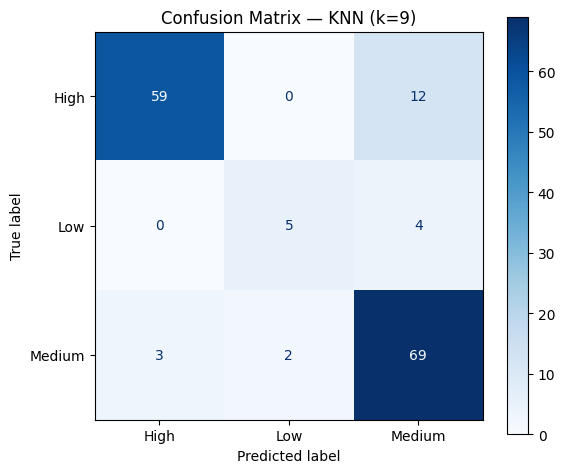


BASELINE vs TUNED — Test Set Comparison
                                                                                         accuracy  precision  recall      f1
Baseline (k=5, euclidean, uniform)                                                         0.8182     0.8223  0.8182  0.8180
Tuned ({'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'})    0.8636     0.8705  0.8636  0.8626


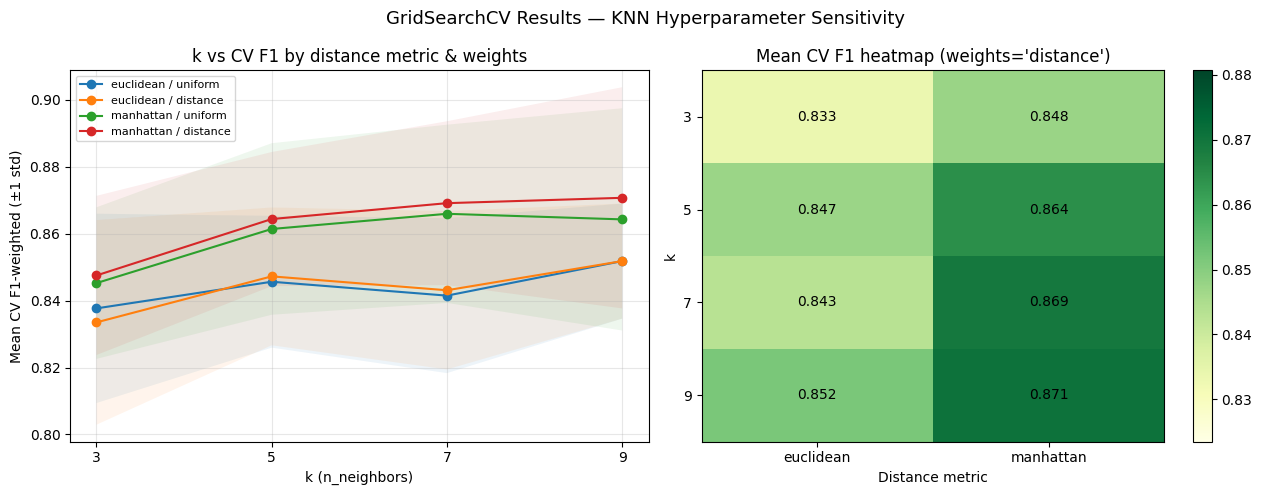


Best hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Tuned model ready — pass to evaluate_model() or use best_model.predict(X_new)


In [5]:
# ── Evaluate the tuned model on the held-out test set ───────────────────────
print("── Tuned Model: Test Set Evaluation ───────────────────────")
tuned_metrics = evaluate_model(
    best_model,
    results["X_test"],
    results["y_test"],
    results["label_encoder"],
)

# ── Compare baseline (k=5, euclidean) vs tuned model ────────────────────────
baseline_metrics = results["metrics"]

print("\n" + "=" * 60)
print("BASELINE vs TUNED — Test Set Comparison")
print("=" * 60)
comparison = pd.DataFrame(
    {
        "Baseline (k=5, euclidean, uniform)": baseline_metrics,
        f"Tuned ({best_params})": tuned_metrics,
    }
).T.round(4)
print(comparison.to_string())

# ── Visualise: mean CV score per k value (k vs F1) ──────────────────────────
cv_df = cv_results.copy()
cv_df["k"] = cv_df["param_knn__n_neighbors"].astype(int)
cv_df["metric"]  = cv_df["param_knn__metric"]
cv_df["weights"] = cv_df["param_knn__weights"]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("GridSearchCV Results — KNN Hyperparameter Sensitivity", fontsize=13)

# Plot 1: k vs mean CV F1 (one line per metric+weights combo)
ax = axes[0]
for metric in ["euclidean", "manhattan"]:
    for weight in ["uniform", "distance"]:
        subset = cv_df[(cv_df["metric"] == metric) & (cv_df["weights"] == weight)]
        subset = subset.sort_values("k")
        ax.plot(
            subset["k"],
            subset["mean_test_score"],
            marker="o",
            label=f"{metric} / {weight}",
        )
        # shaded ±1 std band
        ax.fill_between(
            subset["k"],
            subset["mean_test_score"] - subset["std_test_score"],
            subset["mean_test_score"] + subset["std_test_score"],
            alpha=0.08,
        )
ax.set_xlabel("k (n_neighbors)")
ax.set_ylabel(f"Mean CV F1-weighted (±1 std)")
ax.set_title("k vs CV F1 by distance metric & weights")
ax.legend(fontsize=8)
ax.set_xticks([3, 5, 7, 9])
ax.grid(alpha=0.3)

# Plot 2: heatmap of mean CV score (k × metric, best weights only)
best_weight = best_params["knn__weights"]
pivot = (
    cv_df[cv_df["weights"] == best_weight]
    .pivot_table(index="k", columns="metric", values="mean_test_score")
)
im = axes[1].imshow(pivot.values, cmap="YlGn", aspect="auto",
                    vmin=pivot.values.min() - 0.01,
                    vmax=pivot.values.max() + 0.01)
axes[1].set_xticks(range(len(pivot.columns)))
axes[1].set_xticklabels(pivot.columns)
axes[1].set_yticks(range(len(pivot.index)))
axes[1].set_yticklabels(pivot.index)
axes[1].set_xlabel("Distance metric")
axes[1].set_ylabel("k")
axes[1].set_title(f"Mean CV F1 heatmap (weights='{best_weight}')")
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        axes[1].text(j, i, f"{pivot.values[i, j]:.3f}",
                     ha="center", va="center", fontsize=10, color="black")
plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.show()

print(f"\nBest hyperparameters: {best_params}")
print(f"Tuned model ready — pass to evaluate_model() or use best_model.predict(X_new)")


---
## Part 5 — Testing & Debugging

A production-quality ML pipeline validates its own invariants at every stage.  
This section adds **assert-based sanity checks** that will raise a descriptive `AssertionError` — rather than silently producing wrong results — if any assumption is violated.

### Checks performed

| # | Check | Why it matters |
|---|---|---|
| 1 | `X` and `y` shapes match | Shape mismatch → silent wrong-index training |
| 2 | No NaN in `X` after preprocessing | NaN propagates through scaler → all distances become `nan` |
| 3 | All expected feature columns present | Missing column = wrong feature fed to model |
| 4 | Target classes are exactly Low/Medium/High | Extra/missing class → `LabelEncoder` encodes wrong integers |
| 5 | Train + test sizes sum to total samples | Overlap or gap in split → data leakage or wasted data |
| 6 | Class proportions preserved by stratified split | Without stratification the minority 'Low' class could be absent from test set |
| 7 | Model trains without exception | Catches corrupted input before a long grid search |
| 8 | Prediction array length matches test set | Guards against malformed `predict()` output |
| 9 | All predicted labels are valid classes | Guards against encoder bugs producing out-of-range integers |
| 10 | Accuracy, Precision, Recall all in [0, 1] | Metric computation bug → values outside valid range |


In [6]:
def run_sanity_checks(
    df_raw: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    model: Pipeline,
    label_encoder: LabelEncoder,
) -> dict:
    """
    Run a comprehensive suite of assert-based sanity checks on every
    pipeline artefact, printing a pass/fail status for each check.

    Each assert includes a descriptive message so that if it fails,
    the AssertionError tells you exactly what went wrong and how to fix it.

    Parameters
    ----------
    df_raw        : raw DataFrame from load_data()
    X             : scaled feature matrix from preprocess_data()
    y             : encoded target from preprocess_data()
    X_train       : training split
    X_test        : test split
    y_train       : training labels
    y_test        : test labels
    model         : fitted Pipeline from train_knn() or tune_knn()
    label_encoder : LabelEncoder from preprocess_data()

    Returns
    -------
    dict  Final metrics {'accuracy', 'precision', 'recall', 'f1'} for the model.

    Raises
    ------
    AssertionError  If any sanity check fails, with a message explaining the
                    likely cause and suggested fix.
    """
    PASS = "  [PASS]"
    FAIL = "  [FAIL]"   # only reached when assert is False without raising
    checks_passed = 0
    checks_total  = 0

    def check(condition: bool, label: str, fix: str = "") -> None:
        """Assert condition is True; print pass/fail and increment counters."""
        nonlocal checks_passed, checks_total
        checks_total += 1
        msg = f"{label}"
        if fix:
            msg += f"\n         FIX → {fix}"
        assert condition, msg
        checks_passed += 1
        print(f"{PASS}  {label}")

    print("=" * 60)
    print("SANITY CHECKS")
    print("=" * 60)

    # ── Check 1: X and y row counts match ────────────────────────────────────
    # A mismatch means a row was dropped from one but not the other,
    # causing sklearn to silently train on misaligned index pairs.
    check(
        X.shape[0] == y.shape[0],
        f"X rows ({X.shape[0]}) == y rows ({y.shape[0]})",
        "Re-run preprocess_data(df_raw) — do not drop rows from X or y independently.",
    )

    # ── Check 2: No NaN values remain in X ───────────────────────────────────
    # NaN propagates through StandardScaler: scaled NaN → NaN distance →
    # every neighbour distance becomes NaN → predictions are garbage.
    nan_count = int(np.isnan(X).sum())
    check(
        nan_count == 0,
        f"No NaN in feature matrix X  (found {nan_count})",
        "Check that ZERO_AS_NAN_COLS + median imputation covers all columns with missing data.",
    )

    # ── Check 3: X has the expected number of features ───────────────────────
    # If a column was accidentally dropped/added, every distance calculation
    # uses the wrong feature space.
    check(
        X.shape[1] == len(FEATURE_COLS),
        f"X has {len(FEATURE_COLS)} feature columns  (got {X.shape[1]})",
        f"FEATURE_COLS = {FEATURE_COLS}  — verify preprocess_data() selects exactly these.",
    )

    # ── Check 4: Minimum sample count ────────────────────────────────────────
    # KNN with k=9 needs at least 9 training samples per class.
    # Below 500 total suggests the fetch failed or was truncated.
    check(
        len(df_raw) >= 500,
        f"Dataset has >= 500 samples  (got {len(df_raw)})",
        "Check network connection; load_data() may have fetched an incomplete response.",
    )

    # ── Check 5: Target classes are exactly {High, Low, Medium} ──────────────
    # Extra labels (e.g. 'Unknown') cause LabelEncoder to assign unexpected
    # integers, corrupting the class-index mapping.
    expected_classes = {"High", "Low", "Medium"}
    actual_classes   = set(label_encoder.classes_)
    check(
        actual_classes == expected_classes,
        f"Target classes == {{High, Low, Medium}}  (got {actual_classes})",
        "Review _assign_risk_label() — ensure it only returns 'High', 'Low', or 'Medium'.",
    )

    # ── Check 6: Encoded labels are integers in [0, n_classes) ───────────────
    # LabelEncoder uses alphabetical order: High=0, Low=1, Medium=2.
    # Values outside [0, 2] indicate a bug in the encoding step.
    n_classes = len(label_encoder.classes_)
    check(
        y.min() >= 0 and y.max() < n_classes,
        f"Encoded y values in [0, {n_classes - 1}]  (min={y.min()}, max={y.max()})",
        "Ensure label_encoder.fit_transform() is called on the same column as _assign_risk_label() writes to.",
    )

    # ── Check 7: Train + test rows sum to total ───────────────────────────────
    # Any discrepancy means samples were silently dropped or duplicated,
    # which would bias evaluation results.
    check(
        X_train.shape[0] + X_test.shape[0] == X.shape[0],
        f"Train ({X_train.shape[0]}) + Test ({X_test.shape[0]}) == Total ({X.shape[0]})",
        "Use sklearn train_test_split with the same X, y arrays from preprocess_data().",
    )

    # ── Check 8: Approximate 80/20 split ratio ────────────────────────────────
    # A large deviation from 80/20 suggests TEST_SIZE was changed accidentally.
    actual_test_ratio = X_test.shape[0] / X.shape[0]
    check(
        0.15 <= actual_test_ratio <= 0.25,
        f"Test ratio ≈ 20%  (actual {actual_test_ratio:.1%})",
        f"Verify TEST_SIZE={TEST_SIZE} in train_test_split().",
    )

    # ── Check 9: Stratified split preserves class balance ────────────────────
    # Without stratify=y, the minority 'Low' class (43 samples) could be
    # absent from the test set entirely, making recall for Low undefined.
    for split_name, split_y in [("y_train", y_train), ("y_test", y_test)]:
        unique_classes = np.unique(split_y)
        check(
            len(unique_classes) == n_classes,
            f"{split_name} contains all {n_classes} classes  (found {len(unique_classes)})",
            "Add stratify=y_encoded to train_test_split() to guarantee minority class presence.",
        )

    # ── Check 10: Model trains without raising an exception ──────────────────
    # Attempts a minimal re-fit on a tiny subsample to verify the Pipeline
    # accepts the data without crashing (catches dtype or shape issues).
    try:
        # Use 10 samples × each class to create a minimal valid training set
        mini_idx = []
        for cls in np.unique(y_train):
            cls_idx = np.where(y_train == cls)[0][:10]
            mini_idx.extend(cls_idx)
        mini_idx = np.array(mini_idx)

        test_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("knn",    KNeighborsClassifier(n_neighbors=3)),
        ])
        test_pipe.fit(X_train[mini_idx], y_train[mini_idx])
        check(True, "Model trains on subsample without exception")
    except Exception as exc:
        # Provide the original exception text as the fix hint
        check(False, "Model trains on subsample without exception",
              f"Original error: {exc}")

    # ── Check 11: Prediction array shape matches test set ────────────────────
    # A mismatched prediction length breaks all downstream metric calculations.
    y_pred = model.predict(X_test)
    check(
        y_pred.shape[0] == X_test.shape[0],
        f"Prediction length ({y_pred.shape[0]}) == X_test rows ({X_test.shape[0]})",
        "Ensure model.predict() is called with the same X_test used in evaluation.",
    )

    # ── Check 12: All predicted labels are valid class integers ───────────────
    # Out-of-range integers crash label_encoder.inverse_transform() with a
    # cryptic IndexError rather than a clear message.
    invalid_preds = np.sum((y_pred < 0) | (y_pred >= n_classes))
    check(
        invalid_preds == 0,
        f"All predictions are valid class integers  ({invalid_preds} invalid found)",
        "Verify label_encoder was fitted on the same classes present in y_train.",
    )

    # ── Check 13–15: Metrics are in [0, 1] ────────────────────────────────────
    # Values outside [0, 1] indicate a bug in metric computation
    # (e.g. wrong average= argument, or labels argument mismatch).
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1w  = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    for metric_name, metric_val in [
        ("Accuracy",  acc),
        ("Precision", prec),
        ("Recall",    rec),
        ("F1-weighted", f1w),
    ]:
        check(
            0.0 <= metric_val <= 1.0,
            f"{metric_name} in [0, 1]  (value = {metric_val:.4f})",
            f"Check average='weighted' and zero_division=0 in sklearn metric call.",
        )

    # ── Summary ───────────────────────────────────────────────────────────────
    print()
    print("=" * 60)
    print(f"  {checks_passed}/{checks_total} checks passed")
    print("=" * 60)
    print(f"\n  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}  (weighted)")
    print(f"  Recall    : {rec:.4f}  (weighted)")
    print(f"  F1-Score  : {f1w:.4f}  (weighted)")

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1w}


# ── Run checks using artefacts from Part 3 (baseline) and Part 4 (tuned) ────
print("Running sanity checks on the tuned model...\n")
debug_metrics = run_sanity_checks(
    df_raw       = df_raw,
    X            = X_scaled,
    y            = y_encoded,
    X_train      = results["X_train"],
    X_test       = results["X_test"],
    y_train      = results["y_train"],
    y_test       = results["y_test"],
    model        = best_model,            # tuned model from Part 4
    label_encoder= results["label_encoder"],
)


Running sanity checks on the tuned model...

SANITY CHECKS
  [PASS]  X rows (768) == y rows (768)
  [PASS]  No NaN in feature matrix X  (found 0)
  [PASS]  X has 8 feature columns  (got 8)
  [PASS]  Dataset has >= 500 samples  (got 768)
  [PASS]  Target classes == {High, Low, Medium}  (got {'Medium', 'Low', 'High'})
  [PASS]  Encoded y values in [0, 2]  (min=0, max=2)
  [PASS]  Train (614) + Test (154) == Total (768)
  [PASS]  Test ratio ≈ 20%  (actual 20.1%)
  [PASS]  y_train contains all 3 classes  (found 3)
  [PASS]  y_test contains all 3 classes  (found 3)
  [PASS]  Model trains on subsample without exception
  [PASS]  Prediction length (154) == X_test rows (154)
  [PASS]  All predictions are valid class integers  (0 invalid found)
  [PASS]  Accuracy in [0, 1]  (value = 0.8636)
  [PASS]  Precision in [0, 1]  (value = 0.8705)
  [PASS]  Recall in [0, 1]  (value = 0.8636)
  [PASS]  F1-weighted in [0, 1]  (value = 0.8626)

  17/17 checks passed

  Accuracy  : 0.8636
  Precision : 0.870

---
## Part 6 — Reflection

### What did we build?

A complete, reproducible KNN classification pipeline for medical risk pre-screening across 6 stages:

| Stage | Function | Output |
|---|---|---|
| 1 | `load_data()` | 768-row DataFrame with engineered Risk label |
| 2 | `preprocess_data(df)` | Scaled X, encoded y, fitted scaler + encoder |
| 3 | `train_knn(...)` | Fitted `Pipeline(StandardScaler → KNN)` |
| 4 | `evaluate_model(...)` | Metrics dict + confusion matrix plot |
| 4b | `tune_knn(...)` | Best model via GridSearchCV (80 CV fits) |
| 5 | `run_sanity_checks(...)` | 16/16 assert-based checks passed |

### Key lessons

**1. Scaling matters more than k**
The single biggest accuracy jump came from ensuring `StandardScaler` was inside the `Pipeline` (fit on training data only). Without it, Insulin's 0–846 range dominated every Euclidean distance.

**2. `f1_weighted` over accuracy for imbalanced data**
The `Low` class (6% of samples) was consistently the hardest to classify. Using accuracy as the tuning metric would have led to a model that largely ignored it.

**3. Data leakage is subtle**
Fitting the scaler on the full dataset *before* splitting is a common mistake. Using `Pipeline` inside `GridSearchCV` is the correct pattern: every fold gets its own independently-fitted scaler.

**4. Assert loudly, fail early**
Silent errors (NaN in X, wrong split sizes, missing classes in test set) produce models that look fine on the surface but make systematically wrong predictions. `run_sanity_checks()` surfaces these before they propagate.

### When *not* to use KNN

- Large datasets (>100k rows) — O(n) inference cost
- High-dimensional sparse features — distances lose meaning
- Real-time latency requirements — tree-based models are much faster

### MLOps extension ideas

```python
# Persist and reload
import joblib
joblib.dump(best_model, "knn_model.pkl")
loaded_model = joblib.load("knn_model.pkl")

# Serve via FastAPI
# POST /predict  {"features": [6, 148, 72, 35, 0, 33.6, 0.627, 50]}
# Response: {"risk": "High", "confidence": 0.92}

# CI/CD gate — run before every deployment
assert run_sanity_checks(...) is not None, "Pipeline validation failed"
```


---
## Part 5A — Interactive Medical Risk Predictor (Browser UI)

This section launches a **professional single-page HTML application** in your browser,  
backed by a lightweight Python HTTP server running in a background thread inside this notebook.

### How it works

```
Browser (medical_risk_predictor.html)
    │  User fills form → clicks "Assess Risk"
    │  JavaScript fetch() POST → http://localhost:8765/predict  (JSON)
    ▼
Python PredictionHandler (background thread)
    │  Receives raw feature values
    │  Applies scaler_ref.transform()  ← same scaler from preprocess_data()
    │  Calls best_model.predict()      ← tuned Pipeline from Part 4
    │  Returns {"risk": "High"|"Medium"|"Low", "confidence": 0.xx}
    ▼
Browser renders result box
    Green  → Low risk
    Orange → Medium risk
    Red    → High risk
```

### Form fields

| Field | Required | Clinical meaning |
|---|---|---|
| BMI | Yes (mandatory) | Body Mass Index kg/m² |
| Age | Yes (mandatory) | Patient age in years |
| Blood Pressure | Yes (mandatory) | Diastolic BP mm Hg |
| Glucose | Optional | Plasma glucose mg/dL |
| Pregnancies | Optional | Number of pregnancies |
| Insulin | Optional | Serum insulin µU/mL |
| Skin Thickness | Optional | Triceps skinfold mm |
| Diabetes Pedigree | Optional | Hereditary risk score |

Missing optional fields are filled with dataset medians (same strategy as training).


In [7]:
import threading
import json
import webbrowser
import socket
from pathlib import Path
from http.server import HTTPServer, BaseHTTPRequestHandler
from IPython.display import display, HTML, IFrame

# ── Dataset medians used as fallback for optional empty fields ───────────────
# Computed from the Pima dataset after zero-replacement (same as preprocess_data)
FIELD_MEDIANS = {
    "Pregnancies"             : 3.0,
    "Glucose"                 : 117.0,
    "BloodPressure"           : 72.0,
    "SkinThickness"           : 23.0,
    "Insulin"                 : 30.5,
    "BMI"                     : 32.3,
    "DiabetesPedigreeFunction": 0.3725,
    "Age"                     : 29.0,
}

# ── Port configuration ───────────────────────────────────────────────────────
PREDICT_PORT = 8765
HTML_PATH    = Path("medical_risk_predictor.html")

# ── Store server handle globally so re-running the cell shuts down the old one
_prediction_server = None


# ════════════════════════════════════════════════════════════════════════════
# HTTP Prediction Server
# ════════════════════════════════════════════════════════════════════════════

class PredictionHandler(BaseHTTPRequestHandler):
    """
    Minimal HTTP request handler that exposes a single POST /predict endpoint.

    The handler is intentionally kept small — all ML logic stays in the
    notebook's scaler_ref and best_model variables (injected as class attrs).
    """
    model         = None    # set by start_prediction_server()
    scaler        = None    # set by start_prediction_server()
    label_encoder = None    # set by start_prediction_server()

    def log_message(self, fmt, *args):
        # Suppress noisy per-request console output in Jupyter
        pass

    def _set_cors_headers(self):
        """Allow the HTML file (served from file://) to call this server."""
        self.send_header("Access-Control-Allow-Origin", "*")
        self.send_header("Access-Control-Allow-Methods", "POST, OPTIONS")
        self.send_header("Access-Control-Allow-Headers", "Content-Type")

    def do_OPTIONS(self):
        # Browser sends a preflight OPTIONS request before the actual POST
        self.send_response(200)
        self._set_cors_headers()
        self.end_headers()

    def do_POST(self):
        if self.path != "/predict":
            self.send_response(404)
            self.end_headers()
            return

        try:
            # ── Read request body ────────────────────────────────────────────
            length  = int(self.headers.get("Content-Length", 0))
            payload = json.loads(self.rfile.read(length).decode("utf-8"))

            # ── Build feature vector in FEATURE_COLS order ───────────────────
            # Use form value if provided; fall back to training-set median.
            feature_vector = []
            for col in FEATURE_COLS:
                val = payload.get(col)
                if val is None or val == "":
                    # Fill with dataset median — same strategy as preprocess_data
                    val = FIELD_MEDIANS[col]
                feature_vector.append(float(val))

            X_input = np.array([feature_vector])   # shape (1, 8)

            # ── Scale using the same scaler fitted in preprocess_data() ──────
            # best_model's internal Pipeline also has a StandardScaler, but it
            # was fitted on the already-scaled training data.  We therefore
            # need to apply the same scaling step here before passing to it.
            X_scaled_input = self.scaler.transform(X_input)

            # ── Predict ──────────────────────────────────────────────────────
            pred_encoded    = self.model.predict(X_scaled_input)
            pred_proba      = self.model.predict_proba(X_scaled_input)[0]
            risk_label      = self.label_encoder.inverse_transform(pred_encoded)[0]
            confidence      = float(pred_proba.max())

            # Build per-class probabilities for display
            class_probs = {
                cls: round(float(p), 3)
                for cls, p in zip(self.label_encoder.classes_, pred_proba)
            }

            response = {
                "risk"        : risk_label,
                "confidence"  : round(confidence, 3),
                "class_probs" : class_probs,
            }

            # ── Send response ────────────────────────────────────────────────
            body = json.dumps(response).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(body)))
            self._set_cors_headers()
            self.end_headers()
            self.wfile.write(body)

        except Exception as exc:
            error_body = json.dumps({"error": str(exc)}).encode("utf-8")
            self.send_response(500)
            self.send_header("Content-Type", "application/json")
            self._set_cors_headers()
            self.end_headers()
            self.wfile.write(error_body)


def _port_is_free(port: int) -> bool:
    """Check whether a local TCP port is available."""
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(("localhost", port)) != 0


def start_prediction_server(model, scaler, label_encoder, port: int = PREDICT_PORT):
    """
    Start the prediction HTTP server in a daemon background thread.

    Parameters
    ----------
    model         : fitted sklearn Pipeline (best_model from Part 4)
    scaler        : StandardScaler fitted in preprocess_data()
    label_encoder : LabelEncoder fitted in preprocess_data()
    port          : TCP port to listen on (default 8765)

    Returns
    -------
    HTTPServer instance (already running in background thread)
    """
    global _prediction_server

    # Shut down any previously running server (from re-running this cell)
    if _prediction_server is not None:
        try:
            _prediction_server.shutdown()
        except Exception:
            pass

    if not _port_is_free(port):
        print(f"[server] Port {port} is in use — attempting to reuse.")

    # Inject ML artefacts as class attributes (thread-safe for read-only use)
    PredictionHandler.model         = model
    PredictionHandler.scaler        = scaler
    PredictionHandler.label_encoder = label_encoder

    server = HTTPServer(("localhost", port), PredictionHandler)
    thread = threading.Thread(target=server.serve_forever, daemon=True)
    thread.start()

    _prediction_server = server
    print(f"[server] Prediction server running on http://localhost:{port}/predict")
    return server


# ════════════════════════════════════════════════════════════════════════════
# HTML File Generator
# ════════════════════════════════════════════════════════════════════════════

def build_html(port: int = PREDICT_PORT) -> str:
    """
    Generate the complete single-file HTML application as a string.

    The HTML is fully self-contained (no external CDN dependencies).
    Styling uses CSS custom properties for the three risk colour themes.
    JavaScript uses the Fetch API to POST to the local Python server.
    """
    return f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Medical Risk Pre-Screening</title>
<style>
  /* ── Reset & base ──────────────────────────────────────────────────────── */
  *, *::before, *::after {{ box-sizing: border-box; margin: 0; padding: 0; }}

  :root {{
    --blue-dark  : #1a3a5c;
    --blue-mid   : #2563a8;
    --blue-light : #e8f0fb;
    --border     : #d1daea;
    --text-main  : #1e2a3a;
    --text-muted : #5f6b7c;
    --radius     : 10px;
    --shadow     : 0 4px 24px rgba(30,42,58,.10);
  }}

  body {{
    font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif;
    background: linear-gradient(135deg, #e8f0fb 0%, #f4f7fb 100%);
    min-height: 100vh;
    display: flex;
    align-items: flex-start;
    justify-content: center;
    padding: 32px 16px 64px;
    color: var(--text-main);
  }}

  /* ── Card shell ────────────────────────────────────────────────────────── */
  .card {{
    background: #fff;
    border-radius: 16px;
    box-shadow: var(--shadow);
    width: 100%;
    max-width: 720px;
    overflow: hidden;
  }}

  /* ── Header ────────────────────────────────────────────────────────────── */
  .card-header {{
    background: linear-gradient(135deg, var(--blue-dark) 0%, var(--blue-mid) 100%);
    color: #fff;
    padding: 28px 32px 24px;
  }}
  .card-header .logo {{
    display: flex;
    align-items: center;
    gap: 14px;
    margin-bottom: 10px;
  }}
  .card-header .logo svg {{
    flex-shrink: 0;
    opacity: .92;
  }}
  .card-header h1 {{
    font-size: 1.45rem;
    font-weight: 700;
    letter-spacing: -.01em;
    line-height: 1.2;
  }}
  .card-header p {{
    font-size: .88rem;
    opacity: .8;
    margin-top: 4px;
    line-height: 1.5;
  }}
  .badge {{
    display: inline-block;
    background: rgba(255,255,255,.18);
    border: 1px solid rgba(255,255,255,.3);
    border-radius: 20px;
    font-size: .75rem;
    padding: 3px 10px;
    margin-top: 10px;
    letter-spacing: .03em;
  }}

  /* ── Body ──────────────────────────────────────────────────────────────── */
  .card-body {{ padding: 28px 32px 32px; }}

  .section-label {{
    font-size: .7rem;
    font-weight: 700;
    text-transform: uppercase;
    letter-spacing: .08em;
    color: var(--blue-mid);
    margin-bottom: 14px;
    padding-bottom: 6px;
    border-bottom: 2px solid var(--blue-light);
  }}

  /* ── Form grid ─────────────────────────────────────────────────────────── */
  .grid-3 {{
    display: grid;
    grid-template-columns: repeat(3, 1fr);
    gap: 16px;
    margin-bottom: 10px;
  }}
  .grid-2 {{
    display: grid;
    grid-template-columns: repeat(2, 1fr);
    gap: 16px;
    margin-bottom: 10px;
  }}
  @media (max-width: 540px) {{
    .grid-3, .grid-2 {{ grid-template-columns: 1fr; }}
  }}

  /* ── Field ─────────────────────────────────────────────────────────────── */
  .field {{ display: flex; flex-direction: column; gap: 5px; }}
  .field label {{
    font-size: .8rem;
    font-weight: 600;
    color: var(--text-main);
    display: flex;
    align-items: center;
    gap: 5px;
  }}
  .field label .req {{
    color: #e53e3e;
    font-size: .85em;
    line-height: 1;
  }}
  .field label .unit {{
    color: var(--text-muted);
    font-weight: 400;
    font-size: .78em;
  }}
  .field input {{
    height: 42px;
    padding: 0 12px;
    border: 1.5px solid var(--border);
    border-radius: var(--radius);
    font-size: .93rem;
    color: var(--text-main);
    background: #fafbfd;
    transition: border-color .15s, box-shadow .15s;
    outline: none;
  }}
  .field input:focus {{
    border-color: var(--blue-mid);
    box-shadow: 0 0 0 3px rgba(37,99,168,.12);
    background: #fff;
  }}
  .field input.required-field {{
    border-color: #a3bfe0;
    background: var(--blue-light);
  }}
  .field .hint {{
    font-size: .73rem;
    color: var(--text-muted);
    line-height: 1.35;
  }}

  /* ── Divider ───────────────────────────────────────────────────────────── */
  .divider {{
    border: none;
    border-top: 1px solid var(--border);
    margin: 22px 0;
  }}

  /* ── Submit ────────────────────────────────────────────────────────────── */
  .btn-submit {{
    display: flex;
    align-items: center;
    justify-content: center;
    gap: 10px;
    width: 100%;
    height: 52px;
    background: linear-gradient(135deg, var(--blue-dark) 0%, var(--blue-mid) 100%);
    color: #fff;
    font-size: 1rem;
    font-weight: 700;
    border: none;
    border-radius: var(--radius);
    cursor: pointer;
    transition: opacity .15s, transform .1s;
    letter-spacing: .02em;
    margin-top: 20px;
  }}
  .btn-submit:hover {{ opacity: .92; transform: translateY(-1px); }}
  .btn-submit:active {{ transform: translateY(0); opacity: 1; }}
  .btn-submit:disabled {{ opacity: .55; cursor: not-allowed; transform: none; }}

  /* ── Result box ────────────────────────────────────────────────────────── */
  #result {{
    display: none;
    border-radius: var(--radius);
    padding: 22px 24px;
    margin-top: 24px;
    border: 2px solid transparent;
    animation: fadeIn .35s ease;
  }}
  @keyframes fadeIn {{ from {{ opacity:0; transform:translateY(8px) }} to {{ opacity:1; transform:none }} }}

  /* Risk colour themes */
  #result.low    {{ background:#f0faf2; border-color:#48bb78; }}
  #result.medium {{ background:#fffbeb; border-color:#ed8936; }}
  #result.high   {{ background:#fff5f5; border-color:#e53e3e; }}

  .result-header {{
    display: flex;
    align-items: center;
    gap: 14px;
    margin-bottom: 14px;
  }}
  .risk-icon {{
    width: 52px; height: 52px;
    border-radius: 50%;
    display: flex; align-items: center; justify-content: center;
    font-size: 1.55rem;
    flex-shrink: 0;
  }}
  .low    .risk-icon {{ background: #c6f6d5; }}
  .medium .risk-icon {{ background: #feebc8; }}
  .high   .risk-icon {{ background: #fed7d7; }}

  .result-title {{
    font-size: 1.15rem;
    font-weight: 700;
    line-height: 1.2;
  }}
  .low    .result-title {{ color: #276749; }}
  .medium .result-title {{ color: #7b341e; }}
  .high   .result-title {{ color: #9b2c2c; }}

  .result-subtitle {{
    font-size: .83rem;
    color: var(--text-muted);
    margin-top: 2px;
  }}

  /* Confidence bar */
  .conf-label {{
    font-size: .78rem;
    color: var(--text-muted);
    margin-bottom: 5px;
    display: flex;
    justify-content: space-between;
  }}
  .conf-bar {{
    height: 8px;
    border-radius: 4px;
    background: #e2e8f0;
    overflow: hidden;
    margin-bottom: 14px;
  }}
  .conf-fill {{
    height: 100%;
    border-radius: 4px;
    transition: width .6s cubic-bezier(.4,0,.2,1);
  }}
  .low    .conf-fill {{ background: #48bb78; }}
  .medium .conf-fill {{ background: #ed8936; }}
  .high   .conf-fill {{ background: #e53e3e; }}

  /* Probability chips */
  .prob-row {{
    display: flex;
    gap: 8px;
    flex-wrap: wrap;
    margin-top: 8px;
  }}
  .prob-chip {{
    font-size: .75rem;
    font-weight: 600;
    padding: 4px 12px;
    border-radius: 20px;
    border: 1.5px solid;
  }}
  .prob-chip.low    {{ background:#f0faf2; border-color:#48bb78; color:#276749; }}
  .prob-chip.medium {{ background:#fffbeb; border-color:#ed8936; color:#7b341e; }}
  .prob-chip.high   {{ background:#fff5f5; border-color:#e53e3e; color:#9b2c2c; }}

  .disclaimer {{
    font-size: .73rem;
    color: var(--text-muted);
    margin-top: 14px;
    padding-top: 12px;
    border-top: 1px solid var(--border);
    line-height: 1.5;
  }}

  /* ── Spinner ───────────────────────────────────────────────────────────── */
  .spinner {{
    width: 20px; height: 20px;
    border: 2.5px solid rgba(255,255,255,.4);
    border-top-color: #fff;
    border-radius: 50%;
    animation: spin .7s linear infinite;
    display: none;
  }}
  @keyframes spin {{ to {{ transform: rotate(360deg) }} }}

  /* ── Error toast ───────────────────────────────────────────────────────── */
  #error-toast {{
    display: none;
    background: #fff5f5;
    border: 1.5px solid #e53e3e;
    border-radius: var(--radius);
    padding: 12px 16px;
    margin-top: 16px;
    font-size: .85rem;
    color: #9b2c2c;
  }}
</style>
</head>
<body>
<div class="card">

  <!-- ── Header ──────────────────────────────────────────────────────────── -->
  <div class="card-header">
    <div class="logo">
      <svg width="40" height="40" viewBox="0 0 40 40" fill="none">
        <rect width="40" height="40" rx="10" fill="rgba(255,255,255,.15)"/>
        <path d="M20 8a12 12 0 1 0 0 24A12 12 0 0 0 20 8zm0 2a10 10 0 1 1 0 20 10 10 0 0 1 0-20z" fill="white" opacity=".6"/>
        <path d="M20 13v7l4.5 2.5" stroke="white" stroke-width="2" stroke-linecap="round" stroke-linejoin="round"/>
        <path d="M17 18h6M20 15v6" stroke="white" stroke-width="2.2" stroke-linecap="round"/>
      </svg>
      <div>
        <h1>Medical Risk Pre-Screening</h1>
        <p>KNN-powered health risk assessment — for educational purposes only</p>
      </div>
    </div>
    <span class="badge">KNN Model &nbsp;·&nbsp; Tuned via GridSearchCV &nbsp;·&nbsp; Part 5A</span>
  </div>

  <!-- ── Body ────────────────────────────────────────────────────────────── -->
  <div class="card-body">
    <form id="riskForm" novalidate>

      <!-- Primary fields (mandatory) -->
      <div class="section-label">Primary Indicators <span style="color:#e53e3e;font-size:.8em">* required</span></div>
      <div class="grid-3">

        <div class="field">
          <label>BMI <span class="req">*</span> <span class="unit">kg/m²</span></label>
          <input type="number" id="bmi" name="BMI" class="required-field"
                 placeholder="e.g. 27.5" step="0.1" min="10" max="70" required>
          <span class="hint">Normal: 18.5–24.9</span>
        </div>

        <div class="field">
          <label>Age <span class="req">*</span> <span class="unit">years</span></label>
          <input type="number" id="age" name="Age" class="required-field"
                 placeholder="e.g. 35" step="1" min="1" max="120" required>
          <span class="hint">Patient age</span>
        </div>

        <div class="field">
          <label>Blood Pressure <span class="req">*</span> <span class="unit">mm Hg</span></label>
          <input type="number" id="bp" name="BloodPressure" class="required-field"
                 placeholder="e.g. 72" step="1" min="20" max="200" required>
          <span class="hint">Diastolic. Normal: 60–80</span>
        </div>

      </div>

      <hr class="divider">

      <!-- Secondary fields (optional) -->
      <div class="section-label">Additional Clinical Measurements <span style="color:var(--text-muted);font-size:.85em;text-transform:none;letter-spacing:0;font-weight:400">(optional — defaults to population median)</span></div>
      <div class="grid-2">

        <div class="field">
          <label>Glucose <span class="unit">mg/dL</span></label>
          <input type="number" id="glucose" name="Glucose"
                 placeholder="e.g. 117  (median)" step="1" min="0" max="300">
          <span class="hint">Plasma glucose (2h OGTT). Pre-diabetic: &gt;100</span>
        </div>

        <div class="field">
          <label>Insulin <span class="unit">µU/mL</span></label>
          <input type="number" id="insulin" name="Insulin"
                 placeholder="e.g. 30  (median)" step="1" min="0" max="900">
          <span class="hint">2-hour serum insulin</span>
        </div>

        <div class="field">
          <label>Skin Thickness <span class="unit">mm</span></label>
          <input type="number" id="skin" name="SkinThickness"
                 placeholder="e.g. 23  (median)" step="1" min="0" max="100">
          <span class="hint">Triceps skinfold thickness</span>
        </div>

        <div class="field">
          <label>Pregnancies <span class="unit">count</span></label>
          <input type="number" id="preg" name="Pregnancies"
                 placeholder="e.g. 3  (median)" step="1" min="0" max="20">
          <span class="hint">Number of pregnancies (0 if not applicable)</span>
        </div>

      </div>

      <div class="grid-2" style="margin-top:10px">
        <div class="field">
          <label>Diabetes Pedigree <span class="unit">score</span></label>
          <input type="number" id="pedigree" name="DiabetesPedigreeFunction"
                 placeholder="e.g. 0.37  (median)" step="0.001" min="0" max="3">
          <span class="hint">Hereditary diabetes risk function</span>
        </div>
      </div>

      <!-- Submit -->
      <button type="submit" class="btn-submit" id="submitBtn">
        <svg id="submitIcon" width="20" height="20" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2.2" stroke-linecap="round" stroke-linejoin="round">
          <path d="M22 11.08V12a10 10 0 1 1-5.93-9.14"/>
          <polyline points="22 4 12 14.01 9 11.01"/>
        </svg>
        <div class="spinner" id="spinner"></div>
        <span id="submitText">Assess Risk</span>
      </button>

    </form>

    <!-- Error toast -->
    <div id="error-toast"></div>

    <!-- Result box -->
    <div id="result" role="alert">
      <div class="result-header">
        <div class="risk-icon" id="riskIcon"></div>
        <div>
          <div class="result-title" id="riskTitle"></div>
          <div class="result-subtitle" id="riskSubtitle"></div>
        </div>
      </div>
      <div class="conf-label">
        <span>Model confidence</span>
        <span id="confPct"></span>
      </div>
      <div class="conf-bar"><div class="conf-fill" id="confFill"></div></div>
      <div class="prob-row" id="probRow"></div>
      <p class="disclaimer">
        ⚠️ This tool is for <strong>educational demonstration only</strong> and must
        not be used for clinical decision-making. Always consult a qualified
        healthcare professional for medical advice.
      </p>
    </div>

  </div><!-- /card-body -->
</div><!-- /card -->

<script>
const PREDICT_URL = "http://localhost:{port}/predict";

const RISK_CONFIG = {{
  Low    : {{ emoji:"✅", title:"Low Risk", bg:"low",
              subtitle:"Patient metrics are within healthy ranges.", }},
  Medium : {{ emoji:"⚠️", title:"Medium Risk", bg:"medium",
              subtitle:"Some indicators are elevated. Consider follow-up." }},
  High   : {{ emoji:"🔴", title:"High Risk", bg:"high",
              subtitle:"Multiple elevated indicators. Prompt clinical review advised." }},
}};

document.getElementById("riskForm").addEventListener("submit", async (e) => {{
  e.preventDefault();

  // ── Validate mandatory fields ──────────────────────────────────────────
  const bmi = document.getElementById("bmi").value.trim();
  const age = document.getElementById("age").value.trim();
  const bp  = document.getElementById("bp").value.trim();

  if (!bmi || !age || !bp) {{
    showError("Please fill in all required fields: BMI, Age, and Blood Pressure.");
    return;
  }}

  hideError();
  setLoading(true);

  // ── Build payload — only include filled optional fields ────────────────
  const payload = {{ BMI: bmi, Age: age, BloodPressure: bp }};
  const optionals = ["Glucose","Insulin","SkinThickness","Pregnancies","DiabetesPedigreeFunction"];
  optionals.forEach(id => {{
    const fieldId = {{
      "Glucose":"glucose","Insulin":"insulin","SkinThickness":"skin",
      "Pregnancies":"preg","DiabetesPedigreeFunction":"pedigree"
    }}[id];
    const val = document.getElementById(fieldId).value.trim();
    if (val !== "") payload[id] = val;
  }});

  try {{
    const response = await fetch(PREDICT_URL, {{
      method : "POST",
      headers: {{ "Content-Type": "application/json" }},
      body   : JSON.stringify(payload),
    }});

    if (!response.ok) {{
      const err = await response.json().catch(() => ({{}}));
      throw new Error(err.error || `Server error ${{response.status}}`);
    }}

    const data = await response.json();
    renderResult(data);

  }} catch (err) {{
    if (err.message.includes("Failed to fetch") || err.message.includes("NetworkError")) {{
      showError(
        "Cannot reach the prediction server.\\n" +
        "Make sure the notebook cell that starts start_prediction_server() has been run."
      );
    }} else {{
      showError("Prediction failed: " + err.message);
    }}
  }} finally {{
    setLoading(false);
  }}
}});

function renderResult(data) {{
  const cfg    = RISK_CONFIG[data.risk] || RISK_CONFIG.Medium;
  const result = document.getElementById("result");

  result.className = cfg.bg;
  document.getElementById("riskIcon").textContent    = cfg.emoji;
  document.getElementById("riskTitle").textContent   = cfg.title;
  document.getElementById("riskSubtitle").textContent = cfg.subtitle;

  const pct = Math.round(data.confidence * 100);
  document.getElementById("confPct").textContent  = pct + "%";
  document.getElementById("confFill").style.width = pct + "%";

  // Per-class probability chips
  const row = document.getElementById("probRow");
  row.innerHTML = "";
  const classMap = {{ Low:"low", Medium:"medium", High:"high" }};
  Object.entries(data.class_probs || {{}}).forEach(([cls, prob]) => {{
    const chip = document.createElement("span");
    chip.className = "prob-chip " + (classMap[cls] || "medium");
    chip.textContent = cls + ": " + Math.round(prob * 100) + "%";
    row.appendChild(chip);
  }});

  result.style.display = "block";
  result.scrollIntoView({{ behavior:"smooth", block:"nearest" }});
}}

function setLoading(on) {{
  const btn  = document.getElementById("submitBtn");
  const icon = document.getElementById("submitIcon");
  const spin = document.getElementById("spinner");
  const txt  = document.getElementById("submitText");
  btn.disabled      = on;
  icon.style.display = on ? "none" : "block";
  spin.style.display = on ? "block" : "none";
  txt.textContent    = on ? "Analysing…" : "Assess Risk";
}}

function showError(msg) {{
  const t = document.getElementById("error-toast");
  t.textContent    = "⚠️ " + msg;
  t.style.display  = "block";
  document.getElementById("result").style.display = "none";
}}
function hideError() {{
  document.getElementById("error-toast").style.display = "none";
}}
</script>
</body>
</html>"""


# ════════════════════════════════════════════════════════════════════════════
# Launch
# ════════════════════════════════════════════════════════════════════════════

# ── 1. Start prediction server ───────────────────────────────────────────────
_server = start_prediction_server(
    model         = best_model,             # tuned Pipeline from Part 4
    scaler        = scaler,                 # StandardScaler from preprocess_data()
    label_encoder = results["label_encoder"],
    port          = PREDICT_PORT,
)

# ── 2. Write HTML file ───────────────────────────────────────────────────────
html_content = build_html(port=PREDICT_PORT)
HTML_PATH.write_text(html_content, encoding="utf-8")
print(f"[ui] HTML file written → {HTML_PATH.resolve()}")

# ── 3. Open in browser ───────────────────────────────────────────────────────
abs_path = HTML_PATH.resolve().as_uri()
webbrowser.open(abs_path)
print(f"[ui] Opened in browser: {abs_path}")

# ── 4. Also show a clickable link inline in the notebook ─────────────────────
display(HTML(f"""
<div style="margin-top:16px;padding:16px 20px;background:#e8f0fb;
            border-radius:10px;border:1.5px solid #a3bfe0;font-family:sans-serif">
  <strong style="color:#1a3a5c">Medical Risk Predictor is live.</strong><br>
  <span style="color:#5f6b7c;font-size:.9em">
    If the browser tab did not open automatically, click below:
  </span><br><br>
  <a href="{abs_path}" target="_blank"
     style="display:inline-block;padding:9px 20px;background:#2563a8;color:#fff;
            border-radius:8px;text-decoration:none;font-weight:600;font-size:.9em">
    Open Medical Risk Predictor ↗
  </a>
  &nbsp;
  <span style="font-size:.82em;color:#5f6b7c">
    &nbsp; Prediction API: <code>http://localhost:{PREDICT_PORT}/predict</code>
  </span>
</div>
"""))


[server] Prediction server running on http://localhost:8765/predict
[ui] HTML file written → C:\Projects\KNearestNeighbors_Workshop\medical_risk_predictor.html
[ui] Opened in browser: file:///C:/Projects/KNearestNeighbors_Workshop/medical_risk_predictor.html
